# Predicting the Price of houses with PySpark

In [1]:
import numpy as np
from os.path import expanduser
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

#### Creating a spark session - First, creating spark context, and then creating a session for SQL-like manipulation the Data

In [5]:
#SRC_PATH = expanduser("~") + '/SageMaker/mastering-ml-on-aws/chapter3/'
SRC_PATH = 'boston-housing-dataset/'
sc = SparkContext('local', 'test')
sql = SQLContext(sc)

#### Creating a dataset to train the data

In [6]:
housing_df = sql.read.csv(SRC_PATH + 'train.csv', header= True, inferSchema= True)
housing_df.show(10)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
| ID|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|MEDV|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|7.52601| 0.0| 18.1|   0|0.713|6.417|98.3| 2.185| 24|666|   20.2|304.21|19.31|13.0|
|  2| 0.0136|75.0|  4.0|   0| 0.41|5.888|47.6|7.3197|  3|469|   21.1| 396.9| 14.8|18.9|
|  3|0.05789|12.5| 6.07|   0|0.409|5.878|21.4| 6.498|  4|345|   18.9|396.21|  8.1|22.0|
|  4|0.05646| 0.0|12.83|   0|0.437|6.232|53.7|5.0141|  5|398|   18.7| 386.4|12.34|21.2|
|  5|2.14918| 0.0|19.58|   0|0.871|5.709|98.5|1.6232|  5|403|   14.7|261.95|15.79|19.4|
|  6|0.22876| 0.0| 8.56|   0| 0.52|6.405|85.4|2.7147|  5|384|   20.9|  70.8|10.63|18.6|
|  7|0.00906|90.0| 2.97|   0|  0.4|7.088|20.8|7.3073|  1|285|   15.3|394.72| 7.85|32.2|
|  8|0.03961| 0.0| 5.19|   0|0.515|6.037|34.5|5.9853|  5|224|   20.2| 396.9| 8.01|21.1|
|  9|0.53412|20.0| 3.97|   0|0.6

In [7]:
housing_df.cache()
housing_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)



    Apache spark requires the input dataset to have a single column with a vector of numbers representing all the training  features.

In [8]:
#all features to training without ID and MEDV
training_features = [x for x in housing_df.columns if x not in ['ID', 'MEDV']]
vector_assembler = VectorAssembler(inputCols=training_features, outputCol="features")

df_with_features_vector = vector_assembler.transform(housing_df)
df_with_features_vector.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
| ID|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|MEDV|            features|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|  1|7.52601| 0.0| 18.1|   0|0.713|6.417|98.3| 2.185| 24|666|   20.2|304.21|19.31|13.0|[7.52601,0.0,18.1...|
|  2| 0.0136|75.0|  4.0|   0| 0.41|5.888|47.6|7.3197|  3|469|   21.1| 396.9| 14.8|18.9|[0.0136,75.0,4.0,...|
|  3|0.05789|12.5| 6.07|   0|0.409|5.878|21.4| 6.498|  4|345|   18.9|396.21|  8.1|22.0|[0.05789,12.5,6.0...|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
only showing top 3 rows



In [9]:
#Split the data in train and test
train_df, test_df = df_with_features_vector.randomSplit([0.8, 0.2])

##  Training and Testing a Machinne Learning Model

## Linear Regression

In [10]:
linear = LinearRegression(featuresCol="features", labelCol="MEDV")
linear_model = linear.fit(train_df)

predictions_df = linear_model.transform(test_df)
predictions_df.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+------------------+
| ID|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|MEDV|            features|        prediction|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+------------------+
|  4|0.05646| 0.0|12.83|   0|0.437|6.232|53.7|5.0141|  5|398|   18.7| 386.4|12.34|21.2|[0.05646,0.0,12.8...|   21.243715251433|
|  7|0.00906|90.0| 2.97|   0|  0.4|7.088|20.8|7.3073|  1|285|   15.3|394.72| 7.85|32.2|[0.00906,90.0,2.9...|32.138304218784896|
|  9|0.53412|20.0| 3.97|   0|0.647| 7.52|89.4|2.1398|  5|264|   13.0|388.37| 7.26|43.1|[0.53412,20.0,3.9...| 36.02289220375284|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+------------------+
only showing top 3 rows



    Summarize the model over the training set and print out some metrics:

In [11]:
trainingSummary = linear_model.summary
print("R Squared (R2) on test data: %f" % trainingSummary.r2)
print("Root Mean Squared Error (RMSE) on test data: %f" % trainingSummary.rootMeanSquaredError)

R Squared (R2) on test data: 0.729246
Root Mean Squared Error (RMSE) on test data: 4.680199


    Looking the perfomance of the model in test data

In [12]:
evaluator_r2 = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")
print("R Squared (R2) on test data: %g" % evaluator_r2.evaluate(predictions_df))
evaluator_rmse = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data: %g" % evaluator_rmse.evaluate(predictions_df))

R Squared (R2) on test data: 0.692145
Root Mean Squared Error (RMSE) on test data: 4.54441


## Models

Now, we will run and summarize some models:
   - **Linear Regression** 
   - **Decision Tree Regression**
   - **Gradient Boosting Regressor**
   - **Random Forest Regressor**

In [47]:
def compile_model(model, train_df, test_df):
    train_model = model.fit(train_df)
    predictions = train_model.transform(test_df)
    print(model)
    evaluator_r2 = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")
    print("R Squared (R2) on test data: %g" % evaluator_r2.evaluate(predictions))
    evaluator_rmse = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="rmse")
    print("Root Mean Squared Error (RMSE) on test data: %g" % evaluator_rmse.evaluate(predictions))

    
model_linear = LinearRegression(featuresCol="features", labelCol="MEDV")    
model_DecionTree = DecisionTreeRegressor(featuresCol ='features', labelCol = 'MEDV')
model_gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MEDV', maxIter=10)


model_rf = RandomForestRegressor(featuresCol= 'features', labelCol= 'MEDV')
rf = model_rf.fit(train_df)

In [40]:
compile_model(model_rf, train_df, test_df)

RandomForestRegressor_c7d098e92c22
R Squared (R2) on test data: 0.841643
Root Mean Squared Error (RMSE) on test data = 3.25929


Text(0.5, 1.0, 'Feature Importances')

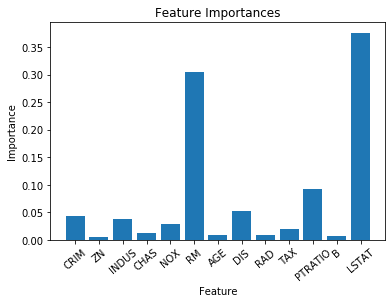

In [48]:
import matplotlib.pyplot as plt

importances = rf.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, training_features, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## HYPERPARAMETER GRID

    The hyperparameter grid predefines parameter values to test when we run the model. The model is iteratively reevaluated using cross-validation for each combination of parameter values. 

    Depending on the environment, testing too many parameters may be too computationally expensive and lead to poor performance. Users might consider adaptive sampling techniques to reduce the number of evaluations.

#### Random Forest Regressor

In [17]:
rf = RandomForestRegressor(featuresCol="features", labelCol="MEDV")
pipeline = Pipeline(stages=[vector_assembler, rf])

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

evaluator = RegressionEvaluator(labelCol="MEDV", predictionCol="prediction", metricName="r2")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=10)

optimized_model = crossval.fit(housing_df)

In [18]:
[(k.name, v) for (k, v) in optimized_model.bestModel.stages[1].extractParamMap().items()]

[('cacheNodeIds', False),
 ('checkpointInterval', 10),
 ('featureSubsetStrategy', 'auto'),
 ('featuresCol', 'features'),
 ('impurity', 'variance'),
 ('labelCol', 'MEDV'),
 ('maxBins', 32),
 ('maxDepth', 25),
 ('maxMemoryInMB', 256),
 ('minInfoGain', 0.0),
 ('minInstancesPerNode', 1),
 ('numTrees', 50),
 ('predictionCol', 'prediction'),
 ('seed', -8735781477787670039),
 ('subsamplingRate', 1.0)]

In [19]:
optimized_model.avgMetrics


[0.8215622083886513,
 0.8392666108601831,
 0.8393018036075542,
 0.8439429181794826,
 0.8611486373486301,
 0.8610827871364577,
 0.8432089209705431,
 0.8696170022249725,
 0.8696463973437624]

In [20]:
_, evaluation_df = housing_df.randomSplit([0.8, 0.2], seed=17)
evaluator.evaluate(optimized_model.transform(evaluation_df))

0.9849675881033293

#### Linear Regression

In [ ]:
linear = LinearRegression(featuresCol="features", labelCol="MEDV")
pipeline = Pipeline(stages=[vector_assembler, linear])
param_grid = ParamGridBuilder() \
    .addGrid(linear.elasticNetParam, [0.01, 0.02, 0.05]) \
    .addGrid(linear.solver, ['normal', 'l-bfgs']) \
    .addGrid(linear.regParam, [0.4, 0.5, 0.6]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=10)

optimized_model = crossval.fit(housing_df)

In [ ]:
[(k.name, v) for (k, v) in optimized_model.bestModel.stages[1].extractParamMap().items()]


In [ ]:
optimized_model.avgMetrics


In [ ]:
_, evaluation_df = housing_df.randomSplit([0.8, 0.2], seed=17)
evaluator.evaluate(optimized_model.transform(evaluation_df))
